# <ins>Sentiment Analysis: "Covid Vaccine" on Twitter</ins>
## Classification Modeling
## Overview
In this notebook I begin classifying my preprocessed tweets about the COVID-19 vaccine that I saved and pickled in the previous [EDA](https://github.com/davidlebruce/covid_vaccine_tweets/blob/main/03_EDA.ipynb) notebook. In order to use text data in my models I first needed to vectorize the text and create a sparse matrix (mostly filled with zeros) of Term Frequency - Inter-Document Frequency (Tfidf) values. The Tfidf value is simply the amount of times a term appears in a tweet, divided by the number of times it shows up in the corpus I used Scikit_Learn's TfidfVectorizer to accomplish this. As you move throughout the notebook you'll see how I navigate from my first simple model, a multinomial naive bayes, to my final model, a more complex support vector machine, and the thought process behind each step.

#### Model Evaluation Metrics
I chose to evaluate my models on their F1 scores as this strikes a good balance between precision and recall, and a model cannot produce a strong F1 score without being strong in both. I'll also be inspecting their accuracy as I interpret the results of each model, making sure none of them are overfitting to my training data. From my perspective there are no significant risks in overcompensating for misclassifying tweets as either positive, negative, or neutral, so evaluating on the F1  accounts for all angles.

In [1]:
# standard python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# sklearn modeling packages
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# optimize viewing
pd.set_option('max_colwidth', 150)
pd.set_option('display.max_columns', 200)

# NLP Feature Engineering 

In [2]:
# unpickle cleaned tweets dataframe
df = pd.read_pickle('./data/modeling_df.pkl')

In [3]:
# confirm data is as it should be
df.head()

,date,tweet,username,link,nlikes,nreplies,nretweets,vader_score,vader_sentiment,clean_tweets
0,2020-02-28,"For everyone comparing COVID-19 to the flu, just a reminder that even with vaccines the flu kills tens of thousands a year. Now imagine a more dea...",MonaIbrahim,https://twitter.com/MonaIbrahim/status/1233542386669641728,3,0,0,-0.8598,negative,everyone compare flu reminder even flu kill ten thousand year imagine much deadly assurance develope affordable hello pandemic
1,2020-02-28,"“Perhaps more than any other type of medicine, the success of a #vaccine depends on the cooperation of everyone. To protect those who can’t have a...",Moratel_Entles,https://twitter.com/Moratel_Entles/status/1233542196193824769,1,0,0,0.7430,positive,perhaps much type medicine success depend cooperation everyone protect young promise need massive buy population large
2,2020-02-28,Provide pharmaceutical companies with the opportunity to develop this vaccine and drug as soon as possible and to reach mass production. As you kn...,help_4_Iranian,https://twitter.com/help_4_Iranian/status/1233542052161507328,0,0,0,0.4404,positive,provide pharmaceutical company opportunity develop drug soon possible reach mass production know drug produce
3,2020-02-28,From John's Hopkins: 1) Immediate risk of COVID-19 remains low in the U.S. The best way to protect yourself is by practicing the same precaution...,TruthFreedom17,https://twitter.com/TruthFreedom17/status/1233541922108694528,1,1,0,0.3818,positive,john hopkins immediate risk remain low us well way protect practice precaution would use prevent spread respiratory disease currently prevent
4,2020-02-28,If the #stockmarkets keep falling - how confident will you be about a #vaccine for #COVID-19 and funds being available for their development?,notarywise,https://twitter.com/notarywise/status/1233541049903177728,0,0,0,0.3818,positive,stockmarkets keep fall confident fund available development


## Train-Test Split
The train-test split must be done before the vectorizing of the data to avoid any sort of data leakage. If I were to vectorize and then split the data into training and testing, there would certainly be information that my models would train on that is not behaving as completely unseen data.

In [4]:
# set X features and y target
X = df['clean_tweets']
y = df['vader_sentiment']

In [5]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=88)

## Feature Engineering with Tfidf
Now I can vectorize my lemmatized tokens that were created from the preprocessing function in the [EDA](https://github.com/davidlebruce/covid_vaccine_tweets/blob/main/03_EDA.ipynb) notebook. These Tfidf vectors will serve as features in the modeling process by creating numerical values based on how valuable a word is to a particular tweet. I am using scikit Learn's tfidf vectorizer.

In [6]:
# instantiate Tfidf vectorizer where token must appear in at least 30 documents
tfidf = TfidfVectorizer(min_df=30)

# .fit_transform training data
X_train_tfidf = tfidf.fit_transform(X_train)

# .fit testing data
X_test_tfidf = tfidf.transform(X_test)

In [7]:
# convert sparse matrix to pandas dataframe
training_df = pd.DataFrame(X_train_tfidf.todense(), columns = tfidf.get_feature_names())
training_df.shape

(57944, 2970)

In [8]:
# take a look at the dataframe I'll use for modeling
training_df.head()

,abandon,abc,ability,able,abort,abortion,absence,absolute,absolutely,abt,abuse,accelerate,accelerating,accept,acceptable,acceptance,access,accessible,accident,accord,according,account,accurate,achieve,acip,acknowledge,acquire,across,act,action,active,activity,actual,actually,ad,adapt,adarpoonawalla,add,addition,additional,address,adenovirus,adequate,adjuvant,admin,administer,administering,administration,admit,adopt,adult,advance,adverse,advice,advise,advisor,advisory,advocate,affect,afford,affordable,afraid,africa,african,afternoon,age,agency,agenda,agendum,agent,ago,agree,agreement,ah,ahead,ai,aid,aids,aim,air,airline,airlines,airport,aka,al,alarm,alberta,albertbourla,album,alert,alex,alien,alive,allege,allergic,allergy,alliance,allocate,allow,ally,...,warning,warns,warp,wartime,wary,wash,washington,washingtonpost,waste,watch,water,wave,way,weak,weaken,wealth,weapon,wear,weather,web,webinar,website,wednesday,week,weekend,weekly,wef,weird,well,west,western,wh,whatever,whenever,whether,whilst,white,whitehouse,who,whoever,whole,whose,wide,widely,widespread,wife,wild,win,window,wing,winner,winter,wipe,wire,wired,wise,wish,within,without,woman,wonder,wont,word,work,worker,workers,working,world,worldwide,worry,worse,worth,would,wow,write,wrong,wsj,wtf,wuhan,yahoo,yahoofinance,yall,yeah,year,yearly,years,yep,yes,yesterday,yet,yo,york,young,youtube,yr,yrs,zero,zinc,zombie,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.296531,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

## Naive Bayes
I chose to begin my modeling process with a simple multinomial naive bayes because there are very few hyperparameters to tune and it is known to work exceptionally well with text classification.

In [9]:
# instantiate multinomial naive bayes object
nb_clf = MultinomialNB()

# train naive bayes
nb_clf = nb_clf.fit(X_train_tfidf, y_train)

# predict on train and test
y_train_preds = nb_clf.predict(X_train_tfidf)
y_test_preds = nb_clf.predict(X_test_tfidf)

In [10]:
print('Training Accuracy: ', accuracy_score(y_train, y_train_preds))
print('Testing Accuracy: ', accuracy_score(y_test, y_test_preds))
print('\n')
print('Training F1: ', f1_score(y_train, y_train_preds, average='weighted'))
print('Testing F1: ', f1_score(y_test, y_test_preds, average='weighted'))

Training Accuracy:  0.7198156841087947
Testing Accuracy:  0.7101734403313487


Training F1:  0.7173072211999172
Testing F1:  0.7074284360541437


In [11]:
# classes to be used for labels on confusion matrix
classes = ['Negative', 'Neutral', 'Positive']

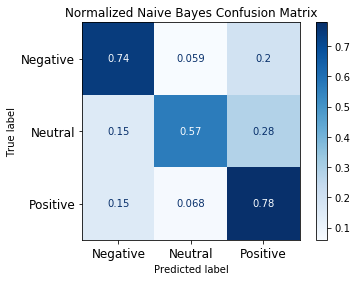

In [33]:
# normalized confusion matrix
disp = plot_confusion_matrix(nb_clf, X_test_tfidf, y_test,
                                 display_labels=classes,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('Normalized Naive Bayes Confusion Matrix')
plt.tick_params(labelsize='large')
plt.savefig('images/nb_matrix.png');

My naive bayes classifier did not perform to badly as a baseline model. Judging by the pale blue in the center of the confusion matrix, the model has a harder time distinguishing the neutral class, but the good news is that the model does not appear to be overfitting to the dataset.

## Support Vector Machine
Support Vector Machine (SVM) is another model known for classifying text based data well. One of the requirements that make text data and SVMs compatible is scaled data. The features I engineered with Tfidf are all on the same scale. 

In [13]:
# instantiate SVC object
svm_clf = SVC(random_state=88)

# train SVC
svm_clf = svm_clf.fit(X_train_tfidf, y_train)

# predict on train and test
y_train_preds = svm_clf.predict(X_train_tfidf)
y_test_preds = svm_clf.predict(X_test_tfidf)

In [14]:
print('Training Accuracy: ', accuracy_score(y_train, y_train_preds))
print('Testing Accuracy: ', accuracy_score(y_test, y_test_preds))
print('\n')
print('Training F1: ', f1_score(y_train, y_train_preds, average='weighted'))
print('Testing F1: ', f1_score(y_test, y_test_preds, average='weighted'))

Training Accuracy:  0.9513668369460169
Testing Accuracy:  0.8440072482526534


Training F1:  0.9513552923745263
Testing F1:  0.843828141085984


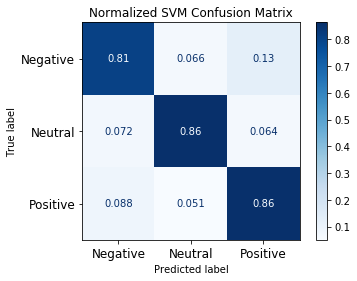

In [34]:
# normalized confusion matrix
disp = plot_confusion_matrix(svm_clf, X_test_tfidf, y_test,
                                 display_labels=classes,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('Normalized SVM Confusion Matrix')
plt.tick_params(labelsize='large')
plt.savefig('images/svm_matrix.png');

For an untuned model, this SVM performed even better than the baseline by a significant margin. I'll explore hyperparameter tuning to see if I can gain any accuracy and improvements in my F1 score.

## Stochastic Gradient Descent
Even though my SVC performed so well on it's pilot run through, I want to see how Stochastic Gradient Descent (SGD) will perform with this classification task before I move on to more involved ensemble methods of modeling with my data.

In [16]:
# instantiate SVM object
sgd_clf = SGDClassifier(random_state=88)

# train SVM
sgd_clf = sgd_clf.fit(X_train_tfidf, y_train)

# predict on train and test
y_train_preds = sgd_clf.predict(X_train_tfidf)
y_test_preds = sgd_clf.predict(X_test_tfidf)

In [17]:
print('Training Accuracy: ', accuracy_score(y_train, y_train_preds))
print('Testing Accuracy: ', accuracy_score(y_test, y_test_preds))
print('\n')
print('Training F1: ', f1_score(y_train, y_train_preds, average='weighted'))
print('Testing F1: ', f1_score(y_test, y_test_preds, average='weighted'))

Training Accuracy:  0.8276957061990887
Testing Accuracy:  0.8135128138752266


Training F1:  0.8273856028346297
Testing F1:  0.813253398458277


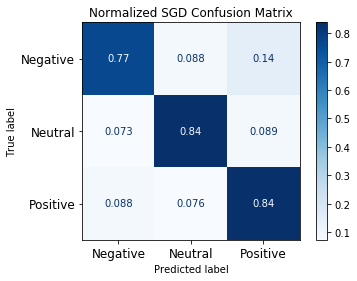

In [35]:
# normalized confusion matrix
disp = plot_confusion_matrix(sgd_clf, X_test_tfidf, y_test,
                                 display_labels=classes,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('Normalized SGD Confusion Matrix')
plt.tick_params(labelsize='large')
plt.savefig('images/sgd_matrix.png');

Not as good as my SVC model, but still fairly good accuracy for an untuned SGD model.

## RandomForest
Random Forest is an ensemble method of aggregating and averaging a bunch of decision trees in order to avoid overfitting. This will be an attempt with a more complicated model that typically requires significant hyperparameter tuning.

In [37]:
# instantiate RandomForest
rf_clf = RandomForestClassifier(random_state=88, max_depth=4)

# fit data to RandomForest
rf_clf.fit(X_train_tfidf, y_train)

# predict on training and test data
y_train_preds = rf_clf.predict(X_train_tfidf)
y_test_preds = rf_clf.predict(X_test_tfidf)

In [38]:
print('Training Accuracy: ', accuracy_score(y_train, y_train_preds))
print('Testing Accuracy: ', accuracy_score(y_test, y_test_preds))
print('\n')
print('Training F1: ', f1_score(y_train, y_train_preds, average='weighted'))
print('Testing F1: ', f1_score(y_test, y_test_preds, average='weighted'))

Training Accuracy:  0.45625086290211236
Testing Accuracy:  0.455293813098628


Training F1:  0.33937380897850183
Testing F1:  0.33844590830759835


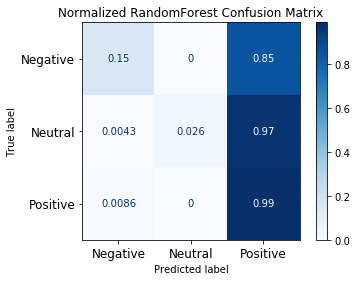

In [39]:
# normalized confusion matrix
disp = plot_confusion_matrix(rf_clf, X_test_tfidf, y_test,
                                 display_labels=classes,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('Normalized RandomForest Confusion Matrix')
plt.tick_params(labelsize='large')
plt.savefig('images/rf_matrix.png');

This RandomForest model did not perform well at all. This is probably symptomatic of the tuning required for RandomForest. I will tinker with the hyperparameters a little bit, but will spend more time exploring the SVM as it performed so well on first pass. 

## RandomForest `class_weight` 'balanced'

In [40]:
# instantiate RandomForest
rf_clf = RandomForestClassifier(random_state=88, class_weight='balanced', max_depth=4)

# fit data to RandomForest
rf_clf.fit(X_train_tfidf, y_train)

# predict on training and test data
y_train_preds = rf_clf.predict(X_train_tfidf)
y_test_preds = rf_clf.predict(X_test_tfidf)

In [41]:
print('Training Accuracy: ', accuracy_score(y_train, y_train_preds))
print('Testing Accuracy: ', accuracy_score(y_test, y_test_preds))
print('\n')
print('Training F1: ', f1_score(y_train, y_train_preds, average='weighted'))
print('Testing F1: ', f1_score(y_test, y_test_preds, average='weighted'))

Training Accuracy:  0.6146796907358829
Testing Accuracy:  0.6181724048666839


Training F1:  0.6139812693451917
Testing F1:  0.6177038548294507


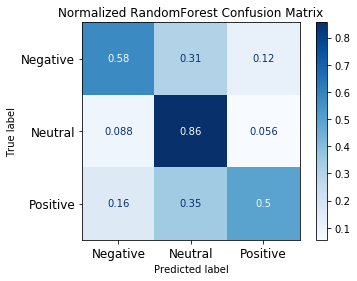

In [42]:
# normalized confusion matrix
disp = plot_confusion_matrix(rf_clf, X_test_tfidf, y_test,
                                 display_labels=classes,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('Normalized RandomForest Confusion Matrix')
plt.tick_params(labelsize='large')
plt.savefig('images/rf_balanced_matrix.png');

Simply altering the 'class_weight' parameter to 'balanced' almost doubled the F1 score for this RandomForest classifier, and it seems to be much better at identifying the neutral class, but still does rather poorly at distinguishing the positive and negative classes. Ultimately it is still underperforming compared to the SVC and SGD classifiers, so I will dedicate more time to improving one of these.

**SVM is the clear winner** of our three vanilla models with scores in the low 80s. The Naive Bayes (NB) classifier and Stochastic Gradient Descent (SGD) classifier were a not too distant second, but NB apparently struggled to identify the neutral class compared to the SVM. The RandomForest performed surprisingly poorly and overpredicted the positive class. I'll take what I have with the SVM, and see if I can improve my accuracy and F1 scores by optimizing hyperparameters with GridSearch.

## Grid Search with SVC Hyperparameters

In [25]:
# setup hyperparameters I want to tune
# param_grid = [{'kernel': ['rbf', 'linear', 'poly'], 'gamma': ['auto', 1e-3, 1e-4, 1, 10],
#                     'C': [0.001, 1, 10, 100]}]

In [26]:
# this cell will take a long time to run

# initialize and fit GridSearch with standard 5 fold CV
# gs_clf = GridSearchCV(SVC(C=1), param_grid, cv=5, scoring='f1_macro', verbose=4)

# gs_clf.fit(X_train_tfidf, y_train)

## Final Model

In [28]:
# instantiate SVC object
gs_clf = SVC(C=100, gamma=1, random_state=88)

# train SVC
gs_clf = gs_clf.fit(X_train_tfidf, y_train)

# predict on train and test
y_train_preds = gs_clf.predict(X_train_tfidf)
y_test_preds = gs_clf.predict(X_test_tfidf)

In [29]:
print('Training Accuracy: ', accuracy_score(y_train, y_train_preds))
print('Testing Accuracy: ', accuracy_score(y_test, y_test_preds))
print('\n')
print('Training F1: ', f1_score(y_train, y_train_preds, average='weighted'))
print('Testing F1: ', f1_score(y_test, y_test_preds, average='weighted'))

Training Accuracy:  0.9967209719729394
Testing Accuracy:  0.8455086720165674


Training F1:  0.9967239632404766
Testing F1:  0.845414573193824


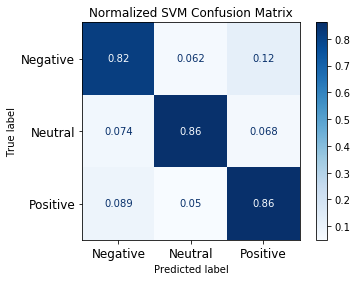

In [43]:
# normalized confusion matrix
disp = plot_confusion_matrix(gs_clf, X_test_tfidf, y_test,
                                 display_labels=classes,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('Normalized SVM Confusion Matrix')
plt.tick_params(labelsize='large')
plt.savefig('images/gs_matrix.png');

Based on the results of my gridsearch, the optimal values for the C parameter wound up to be 100, a relatively high value for this hyperparameter, meaning the penalty for misclassified points is higher in this model. The default radial basis function (RBF) remained and a gamma value of 1 was used. None of this lead to significant improvements in the F1 score, but the cross validation has ensured my model is not overfit and will continue to perform well on unseen data. **This gridsearched SVC model is my final model.**